In [1]:
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt
import matplotlib as mpl

class DBSCAN(object):
    def __init__(self, metric='minkowski', p=2, eps=2, minPoints=2):
        self.metric = metric
        self.p = p
        self.eps=eps
        self.minPoints=minPoints
        self.X = None
        self.labels_ = None
        self._check_metrics()
     
    def _check_metrics(self):
        if self.metric not in ['minkowski', 'manhattan', 'chebyshev']:
            raise ValueError(f'Metric "{self.metric}" is not valid. Use "minkowski", "manhattan", or "chebyshev"')
    
    def __repr__(self):
        return f"""DBSCAN(eps=2, minPoints=2, metric={self.metric}, p={2}))"""
    
    def fit(self, X):
        
        if isinstance(X, pd.core.series.Series):
            X = X.to_numpy()
        if X.ndim==1:
            X = X.reshape(-1,1)
        
        self.X = X
        self.labels_ = np.empty(self.X.shape[0])
        self.labels_[:]=np.nan
        
        self._cluster()
        
        return self
        
    def _cluster(self):
        C=-1
        for index, point in enumerate(self.X):
            if ~np.isnan(self.labels_[index]):
                continue
                
            neighbors, num_neighbors = self.range_query(point)
            
            if num_neighbors<self.minPoints:
                self.labels_[index]=-1
                continue
                
            C=C+1
            
            self.labels_[index]=C
            
            set_of_reachables_indices =  np.delete(neighbors, np.where(neighbors==index))
            q = deque(set_of_reachables_indices)
            while q:
                reachable_indice = q.pop()
                if self.labels_[reachable_indice]==-1:
                    self.labels_[reachable_indice]=C
                if ~np.isnan(self.labels_[reachable_indice]):
                    continue
                self.labels_[reachable_indice]=C
                reachable_neighbors, num_reachable_neighbors = self.range_query(self.X[reachable_indice,:])
                if num_reachable_neighbors>= self.minPoints:
                    q.extend(reachable_neighbors)
        self.labels_ = self.labels_.astype('int')
            
    
    def range_query(self, p):
        along_axis_diffs = self.X[:,np.newaxis,:] - p
        if self.metric == 'minkowski':
            distances = np.power(np.power(np.abs(along_axis_diffs), self.p).sum(axis=-1), 1/self.p)
        if self.metric == 'manhattan':
            distances = np.abs(along_axis_diffs).sum(axis=-1)
        if self.metric == 'chebyshev':
            distances = np.abs(along_axis_diffs).max(axis=-1)
            
        assert distances.shape==(self.X.shape[0],1)
        distances = distances.reshape(-1)
        
        indices = np.argwhere(distances<=self.eps).ravel()
        N = len(indices)
        
        return indices, N
    
def compute_purity(grand_truth, predicts):
    df = pd.DataFrame({'clusters': predicts, 'classes': grand_truth, 'cnt': 1})
    df = pd.crosstab(df.clusters, df.classes)
    return df.to_numpy().max(axis=1).sum()/df.to_numpy().sum()

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  


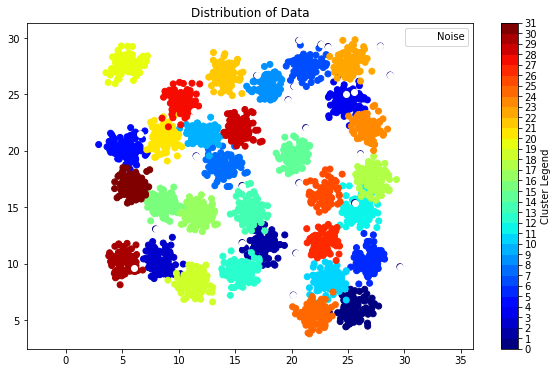

Purity: 99.35


In [33]:
data_d31 = pd.read_table('d31.txt', header=None).to_numpy()
dbscan_d31 = DBSCAN(eps=1, minPoints=7).fit(data_d31)
fig, ax = plt.subplots(figsize=(10,6))

N=np.unique(dbscan_d31.labels_).max()+1
cmap = plt.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0,N,N+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
scat = ax.scatter(data_d31[:,0], data_d31[:,1], 
           cmap=cmap, norm=norm, c=dbscan_d31.labels_)

noise = ax.scatter(data_d31[dbscan_d31.labels_==-1,0], data_d31[dbscan_d31.labels_==-1,1], 
           color='white', label='Noise')
    
cb = plt.colorbar(scat, spacing='proportional',ticks=bounds)
cb.set_label('Cluster Legend')


ax.axis('equal')
ax.legend()
ax.set_title('Distribution of Data')
plt.show()

purity_d31 = compute_purity(data_d31[:,2], dbscan_d31.labels_)
print(f"Purity: {purity_d31*100:.2f}")

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


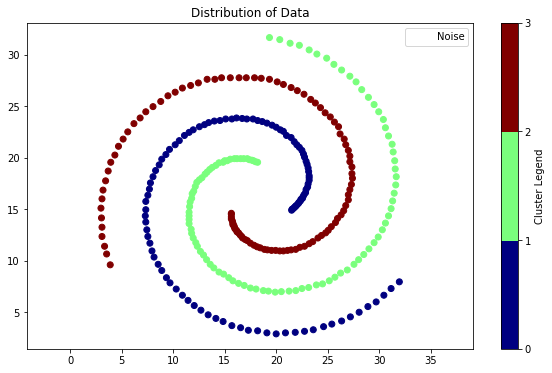

Purity: 100.00


In [34]:
data_spiral = pd.read_table('spiral.txt', header=None).to_numpy()

dbscan_spiral = DBSCAN(eps=2, minPoints=2).fit(data_spiral)
fig, ax = plt.subplots(figsize=(10,6))

N=np.unique(dbscan_spiral.labels_).max()+1
cmap = plt.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0,N,N+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
scat = ax.scatter(data_spiral[:,0], data_spiral[:,1], 
           cmap=cmap, norm=norm, c=dbscan_spiral.labels_)
    
noise = ax.scatter(data_spiral[dbscan_spiral.labels_==-1,0], data_spiral[dbscan_spiral.labels_==-1,1], 
       color='white', label='Noise')

cb = plt.colorbar(scat, spacing='proportional',ticks=bounds)
cb.set_label('Cluster Legend')
    
ax.axis('equal')
ax.set_title('Distribution of Data')
ax.legend()
plt.show()

purity_spiral = compute_purity(data_spiral[:,2], dbscan_spiral.labels_)
print(f"Purity: {purity_spiral*100:.2f}")

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


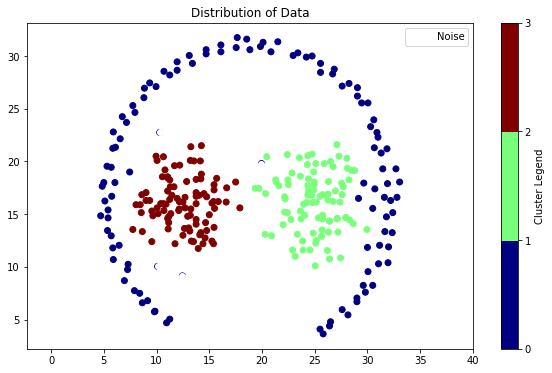

Purity: 99.67


In [5]:
data_pathbased = pd.read_table('pathbased.txt', header=None).to_numpy()
dbscan_pathbased = DBSCAN(eps=2, minPoints=5).fit(data_pathbased)
fig, ax = plt.subplots(figsize=(10,6))

N=np.unique(dbscan_pathbased.labels_).max()+1
cmap = plt.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0,N,N+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
scat = ax.scatter(data_pathbased[:,0], data_pathbased[:,1], 
           cmap=cmap, norm=norm, c=dbscan_pathbased.labels_)
    
noise = ax.scatter(data_pathbased[dbscan_pathbased.labels_==-1,0], data_pathbased[dbscan_pathbased.labels_==-1,1], 
       color='white', label='Noise')

cb = plt.colorbar(scat, spacing='proportional',ticks=bounds)
cb.set_label('Cluster Legend')
    
ax.axis('equal')
ax.set_title('Distribution of Data')
ax.legend()
plt.show()

purity_pathbased = compute_purity(data_pathbased[:,2], dbscan_pathbased.labels_)
print(f"Purity: {purity_pathbased*100:.2f}")

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


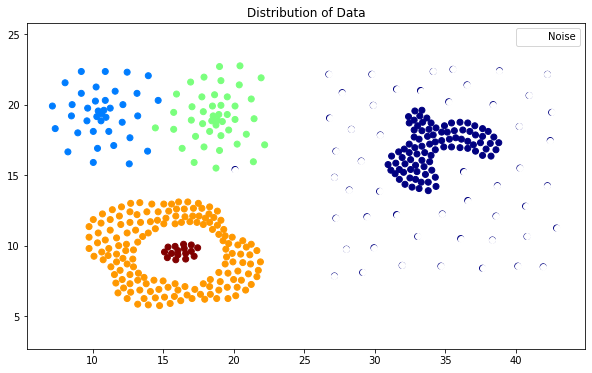

Purity 99.75


In [24]:
data_compound = pd.read_table('Compound.txt', header=None).to_numpy()
dbscan_compound = DBSCAN(eps=1.71, minPoints=5).fit(data_compound)
fig, ax = plt.subplots(figsize=(10,6))

#N=np.unique(dbscan_compound.labels_).max()+1
#cmap = plt.cm.jet
#cmaplist = [cmap(i) for i in range(cmap.N)]
#cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
#bounds = np.linspace(0,N,N+1)
#norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
scat = ax.scatter(data_compound[:,0], data_compound[:,1], 
           cmap=cmap, norm=norm, c=dbscan_compound.labels_)
    
noise = ax.scatter(data_compound[dbscan_compound.labels_==-1,0], data_compound[dbscan_compound.labels_==-1,1], 
       color='white', label='Noise')

#cb = plt.colorbar(scat, spacing='proportional',ticks=bounds)
#cb.set_label('Cluster Legend')
    
ax.axis('equal')
ax.set_title('Distribution of Data')
ax.legend()
plt.show()


purity_compound = compute_purity(data_compound[:,2], dbscan_compound.labels_)
print(f"Purity {purity_compound*100:.2f}")


C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


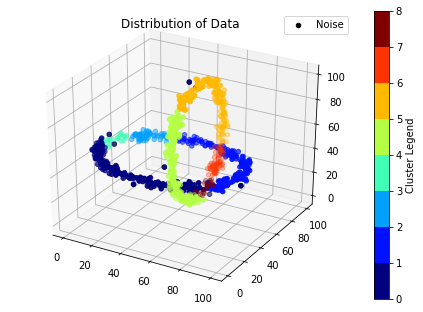

Purity: 99.50


In [32]:
data_ring = pd.read_table('rings.txt', header=None).to_numpy()

data_ring[:,[0, 1]] = data_ring[:,[1, 0]]
data_ring[:,[1, 2]] = data_ring[:,[2, 1]]
data_ring[:,[2, 3]] = data_ring[:,[3, 2]]

dbscan_ring = DBSCAN(eps=4, minPoints=5).fit(data_ring)

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

N=np.unique(dbscan_ring.labels_).max()+1
cmap = plt.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0,N,N+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


scat = ax.scatter(data_ring[:,0], data_ring[:,1],data_ring[:,2],cmap=cmap, norm=norm, c=dbscan_ring.labels_) 
noise = ax.scatter(data_ring[dbscan_ring.labels_==-1,0], data_ring[dbscan_ring.labels_==-1,1],data_ring[dbscan_ring.labels_==-1,2], color='black', label='Noise')

cb = plt.colorbar(scat, spacing='proportional',ticks=bounds)
cb.set_label('Cluster Legend')
    
ax.set_title('Distribution of Data')
ax.legend()
plt.show()

purity_rings = compute_purity(data_ring[:,3], dbscan_ring.labels_)
print(f"Purity: {purity_rings*100:.2f}")